# Trabajo final de Desarrollo en Aplicaciones con Visión Artificial

## Información del Cuadernillo

### Información relevante

- Nombre: Mario Zoser Mena Acha
- Curso: Desarrollo en Aplicaciones con Visión Artificial

### Fuente de datos:

https://gitlab.com/Aleja84/Coleccion-de-imagenes

Fuente:

https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae

## Revisión del dataset

In [ ]:
#pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

### Librerías

In [ ]:
import os
import torch
from urllib.parse import urlparse
from collections import Counter
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#import torchvision.transforms as T
#from engine import train_one_epoch, evaluate
#import utils
#from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T

### Extracción del dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://gitlab.com/aleja84/coleccion-de-imagenes.git

Cloning into 'coleccion-de-imagenes'...
remote: Enumerating objects: 3173, done.
remote: Total 3173 (delta 0), reused 0 (delta 0), pack-reused 3173
Receiving objects: 100% (3173/3173), 3.49 GiB | 36.59 MiB/s, done.
Resolving deltas: 100% (1549/1549), done.
Updating files: 100% (3148/3148), done.


### Asignación de variables

In [ ]:
# Definir las rutas de las carpetas de imágenes y anotaciones
images_path = '/content/drive/MyDrive/PUCP/Diplomado/VA/coleccion-de-imagenes/Imagenes'
annotations_path = '/content/drive/MyDrive/PUCP/Diplomado/VA/coleccion-de-imagenes/Anotaciones'

In [ ]:
# Lista para almacenar la información
image_info_list = []

In [ ]:
# Contador global para todas las categorías
global_category_count = Counter()

In [ ]:
# Función para extraer información de los archivos XML
def extract_info_from_xml(xml_file_name, xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    objects = root.findall('object')
    names = [obj.find('name').text for obj in objects]
    return xml_file_name, names

In [ ]:
# Iterar sobre los archivos XML y extraer la información
for xml_file_name in os.listdir(annotations_path):
    if xml_file_name.endswith('.xml'):
        xml_file_path = os.path.join(annotations_path, xml_file_name)
        file_name, names = extract_info_from_xml(xml_file_name, xml_file_path)
        image_info_list.append((file_name, names))
        # Actualizar el contador global con las categorías de este archivo
        global_category_count.update(names)

In [ ]:
# Imprimir la lista de listas con la información
for info in image_info_list:
    print(info)

('imagen_0838.xml', ['Camion', 'Auto'])
('imagen_1207.xml', ['Camion', 'Excavadora'])
('imagen_0244.xml', ['Camioneta'])
('imagen_0108.xml', ['Excavadora', 'Camion_minero'])
('imagen_0650.xml', ['Camion', 'Camion'])
('imagen_0025.xml', ['Excavadora', 'Camion_minero'])
('imagen_0150.xml', ['Camion'])
('imagen_1082.xml', ['Persona', 'Persona'])
('imagen_1261.xml', ['Camion', 'Auto'])
('imagen_0361.xml', ['Camion', 'Camion', 'Camion', 'Camion', 'Camion', 'Camion', 'Camion', 'Camion', 'Bulldozer', 'Excavadora', 'Camion'])
('imagen_0928.xml', ['Bulldozer'])
('imagen_0765.xml', ['Auto', 'Auto', 'Auto', 'Camion', 'Camion', 'Auto', 'Auto'])
('imagen_0112.xml', ['Camion_minero', 'Excavadora'])
('imagen_1262.xml', ['Camion_minero'])
('imagen_1218.xml', ['Otro', 'Excavadora'])
('imagen_0919.xml', ['Excavadora'])
('imagen_0407.xml', ['Otro', 'Otro', 'Auto', 'Camion'])
('imagen_0359.xml', ['Excavadora', 'Excavadora'])
('imagen_1125.xml', ['Auto'])
('imagen_0905.xml', ['Camion', 'Camion', 'Camion', 

In [ ]:
info

('imagen_0718.xml', ['Camion_minero', 'Camion_minero', 'Excavadora'])

In [ ]:
len(image_info_list)

1300

In [ ]:
# Crear una nueva lista de listas con el nombre del archivo, categorías únicas y conteo global de categorías
category_info_list = []

In [ ]:
for file_name, names in image_info_list:
    # Contar las ocurrencias de cada categoría en este archivo
    local_category_count = Counter(names)
    # Crear una lista con el nombre del archivo y la información de categorías y conteos globales
    file_info = [file_name]
    for category in global_category_count:
        file_info.append((category, local_category_count[category], global_category_count[category]))
    category_info_list.append(file_info)

In [ ]:
# Imprimir la nueva lista de listas con la información
for info in category_info_list:
    print(info)

['imagen_0838.xml', ('Camion', 1, 937), ('Auto', 1, 412), ('Excavadora', 0, 783), ('Camioneta', 0, 240), ('Camion_minero', 0, 900), ('Persona', 0, 496), ('Bulldozer', 0, 151), ('Otro', 0, 243)]
['imagen_1207.xml', ('Camion', 1, 937), ('Auto', 0, 412), ('Excavadora', 1, 783), ('Camioneta', 0, 240), ('Camion_minero', 0, 900), ('Persona', 0, 496), ('Bulldozer', 0, 151), ('Otro', 0, 243)]
['imagen_0244.xml', ('Camion', 0, 937), ('Auto', 0, 412), ('Excavadora', 0, 783), ('Camioneta', 1, 240), ('Camion_minero', 0, 900), ('Persona', 0, 496), ('Bulldozer', 0, 151), ('Otro', 0, 243)]
['imagen_0108.xml', ('Camion', 0, 937), ('Auto', 0, 412), ('Excavadora', 1, 783), ('Camioneta', 0, 240), ('Camion_minero', 1, 900), ('Persona', 0, 496), ('Bulldozer', 0, 151), ('Otro', 0, 243)]
['imagen_0650.xml', ('Camion', 2, 937), ('Auto', 0, 412), ('Excavadora', 0, 783), ('Camioneta', 0, 240), ('Camion_minero', 0, 900), ('Persona', 0, 496), ('Bulldozer', 0, 151), ('Otro', 0, 243)]
['imagen_0025.xml', ('Camion',

In [ ]:
# Diccionario para almacenar los nombres de los archivos por categoría
category_files = {}

In [ ]:
# Lista para almacenar los nombres de los archivos que pertenecen a la categoría "test"
test_files = []

In [ ]:
# Revisar cada archivo en la lista de listas
for file_info in category_info_list:
    file_name = file_info[0]
    categories = file_info[1:]

    # Contar cuántas categorías tienen al menos un elemento
    non_zero_categories = [category for category, local_count, _ in categories if local_count > 0]

    # Si sólo una categoría tiene elementos, almacenar el nombre del archivo en esa categoría
    if len(non_zero_categories) == 1:
        category_name = non_zero_categories[0]
        if category_name not in category_files:
            category_files[category_name] = []
        category_files[category_name].append(file_name)
    # Si hay varias categorías con al menos un elemento, almacenar el nombre del archivo en "test"
    elif len(non_zero_categories) > 1:
        test_files.append(file_name)

In [ ]:
len(non_zero_categories)

2

In [ ]:
non_zero_categories

['Excavadora', 'Camion_minero']

In [ ]:
# Crear la lista de listas final con las categorías y los nombres de los archivos
final_category_list = []

In [ ]:
# Agregar las categorías y los archivos correspondientes a la lista final
for category, files in category_files.items():
    final_category_list.append([category] + files)

In [ ]:
# Agregar la categoría "test" y los archivos correspondientes a la lista final
if test_files:
    final_category_list.append(["test"] + test_files)

In [ ]:
# Imprimir la lista de listas final
for category_list in final_category_list:
    print(category_list)

['Camioneta', 'imagen_0244.xml', 'imagen_0768.xml', 'imagen_1289.xml', 'imagen_0242.xml', 'imagen_1026.xml', 'imagen_1016.xml', 'imagen_1025.xml', 'imagen_0243.xml']
['Camion', 'imagen_0650.xml', 'imagen_0150.xml', 'imagen_0648.xml', 'imagen_0815.xml', 'imagen_0076.xml', 'imagen_0661.xml', 'imagen_1266.xml', 'imagen_0825.xml', 'imagen_1256.xml', 'imagen_0652.xml', 'imagen_0665.xml', 'imagen_0818.xml', 'imagen_0810.xml', 'imagen_1133.xml', 'imagen_0030.xml', 'imagen_1235.xml', 'imagen_0645.xml', 'imagen_0643.xml', 'imagen_1264.xml', 'imagen_0842.xml', 'imagen_0380.xml', 'imagen_0657.xml', 'imagen_0663.xml', 'imagen_1265.xml', 'imagen_0034.xml', 'imagen_0653.xml', 'imagen_0149.xml', 'imagen_1055.xml', 'imagen_0062.xml', 'imagen_0647.xml', 'imagen_0154.xml', 'imagen_0814.xml', 'imagen_0655.xml', 'imagen_0820.xml', 'imagen_0656.xml', 'imagen_0788.xml', 'imagen_1239.xml', 'imagen_0819.xml', 'imagen_1057.xml', 'imagen_1134.xml', 'imagen_0152.xml', 'imagen_0035.xml', 'imagen_0649.xml', 'image

In [ ]:
len(final_category_list)

8

In [ ]:
len(final_category_list[8])

IndexError: list index out of range

## Iniciamos el proceso de estructuración de los datos

### Clases

In [ ]:
categorias = {
    'Persona': 1,
    'Camion_minero': 2,
    'Camion': 3,
    'Excavadora': 4,
    'Bulldozer': 5,
    'Auto': 6,
    'Camioneta': 7,
    'Otro': 8
}


In [ ]:
# Función para parsear un archivo XML individual
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    labels = []
    for member in root.findall('object'):
        labels.append(member.find('name').text)

        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])

    return {'boxes': boxes, 'labels': labels}

# Función para leer todos los archivos XML en la carpeta "anotaciones"
def read_annotations(folder_path):
    annotations = []
    # Lista todos los archivos en la carpeta
    xml_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xml')]

    # Itera sobre los archivos y parsea cada uno
    for xml_file in xml_files:
        annotation = parse_xml(xml_file)
        annotations.append(annotation)

    return annotations


In [ ]:
# Ejemplo para leer los datos de un archivo .XML
xml_path = '/content/coleccion-de-imagenes/Anotaciones/imagen_0001.xml'  # Cambia esto por la ruta real a tus archivos XML
annotations = parse_xml(xml_path)
print(annotations)

{'boxes': [[591, 323, 1170, 567], [25, 476, 320, 666]], 'labels': ['Excavadora', 'Auto']}


In [ ]:
# Ejemplo de uso de la función read_annotations
folder_path = '/content/coleccion-de-imagenes/Anotaciones'  # Ruta a la carpeta con archivos XML
all_annotations = read_annotations(folder_path)

In [ ]:
# Imprime el número de archivos parseados para verificar
print(f"Total XML files parsed: {len(all_annotations)}")

Total XML files parsed: 1572


In [ ]:
all_annotations[0]

{'boxes': [[67, 445, 189, 553], [277, 414, 356, 465], [698, 371, 743, 422]],
 'labels': ['Excavadora', 'Camion_minero', 'Camion_minero']}

In [ ]:
# Función para leer una imagen y convertirla en un array de numpy
def read_image(image_file):
    image = Image.open(image_file)
    image_array = np.array(image)
    return image_array

# Función para leer todas las imágenes en la carpeta "imagenes"
def read_images(folder_path):
    images = []
    # Lista todos los archivos en la carpeta
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png')]

    # Itera sobre los archivos y lee cada imagen
    for image_file in image_files:
        image_array = read_image(image_file)
        images.append(image_array)

    return images

In [ ]:
# Ejemplo de uso de la función read_images
folder_path = '/content/coleccion-de-imagenes/Imagenes'  # Ruta a la carpeta con archivos de imagen
all_images = read_images(folder_path)

In [ ]:
# Imprime el número de imágenes leídas para verificar
print(f"Total PNG images read: {len(all_images)}")

Total PNG images read: 1572


In [ ]:
all_images[0]

## Fine Tuning

### Extracción de códigos fuentes

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

### Librerías

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import xml.etree.ElementTree as ET
from torchvision.transforms import v2 as T
from engine import train_one_epoch, evaluate
import utils
from PIL import Image

In [ ]:
import pycocotools

In [ ]:
!pip install Pillow

### Adecuar el dataset para el modelo de RN

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Imagenes"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "Anotaciones"))))

    def __getitem__(self, idx):
        # Carga la imagen y el archivo XML
        img_path = os.path.join(self.root, "Imagenes", self.imgs[idx])
        box_path = os.path.join(self.root, "Anotaciones", self.boxes[idx])

        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(box_path)
        root = tree.getroot()

        # Aquí se extraen las coordenadas de los cuadros delimitadores y las etiquetas
        boxes = []
        labels = []
        for member in root.findall('object'):
            labels.append(self.class_to_int(member[0].text))
            xmin = int(member[4][0].text)
            ymin = int(member[4][1].text)
            xmax = int(member[4][2].text)
            ymax = int(member[4][3].text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = idx #torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

    def class_to_int(self, label):
        label_map = {'Persona': 1, 'Camion_minero': 2, 'Camion': 3, 'Excavadora': 4,
                     'Bulldozer': 5, 'Auto': 6, 'Camioneta': 7, 'Otro': 8}
        return label_map[label]

In [ ]:
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

### Revisión del dataset

In [ ]:
#dataset = CustomDataset('/content/coleccion-de-imagenes', get_transform(train=True))
dataset = CustomDataset('/content/drive/MyDrive/PUCP/Diplomado/VA/coleccion-de-imagenes_test', get_transform(train=True))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
dataset.__getitem__(7)

### Modelo Pre-Entrenado

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # Cargar un modelo preentrenado
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Obtener el número de características de entrada para el clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Reemplazar la cabeza preentrenada con una nueva
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
#from engine import train_one_epoch, evaluate
#import utils

# Usar una GPU si está disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Nuestro dataset tiene 8 clases + background
num_classes = 9

# Usar nuestro dataset y las transformaciones definidas
dataset = CustomDataset('/content/drive/MyDrive/PUCP/Diplomado/VA/coleccion-de-imagenes', get_transform(train=True))
dataset_test = CustomDataset('/content/drive/MyDrive/PUCP/Diplomado/VA/coleccion-de-imagenes', get_transform(train=False))

# Dividir el dataset en train y test
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Definir los data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


We have: 1300 examples, 1250 are training and 50 testing


### Obtener el modelo

In [ ]:
# Obtener el modelo
model = get_model(num_classes)
model.to(device)

# Definir el optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Y el scheduler del learning rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Entrenar durante 05 epochs, se prueba con 10 y no termina de ejecutar
num_epochs = 50

for epoch in range(num_epochs):
    # Entrenar una epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Actualizar el learning rate
    lr_scheduler.step()
    # Evaluar en el conjunto de validación
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/625]  eta: 0:04:12  lr: 0.000013  loss: 2.8098 (2.8098)  loss_classifier: 1.7561 (1.7561)  loss_box_reg: 0.2651 (0.2651)  loss_objectness: 0.7343 (0.7343)  loss_rpn_box_reg: 0.0543 (0.0543)  time: 0.4037  data: 0.2762  max mem: 2506
Epoch: [0]  [ 10/625]  eta: 0:01:24  lr: 0.000093  loss: 2.1610 (2.2081)  loss_classifier: 1.7180 (1.6414)  loss_box_reg: 0.1526 (0.2172)  loss_objectness: 0.1342 (0.3182)  loss_rpn_box_reg: 0.0190 (0.0313)  time: 0.1380  data: 0.0348  max mem: 2506
Epoch: [0]  [ 20/625]  eta: 0:01:14  lr: 0.000173  loss: 1.6830 (1.7755)  loss_classifier: 1.3169 (1.2170)  loss_box_reg: 0.1515 (0.2217)  loss_objectness: 0.0899 (0.3062)  loss_rpn_box_reg: 0.0190 (0.0306)  time: 0.1100  data: 0.0102  max mem: 2506
Epoch: [0]  [ 30/625]  eta: 0:01:12  lr: 0.000253  loss: 0.7890 (1.4359)  loss_classifier: 0.4047 (0.9228)  loss_box_reg: 0.1894 (0.2140)  loss_objectness: 0.0834 (0.2643)  loss_rpn_box_reg: 0.0269 (0.0347)  time: 0.1129  data: 0.0111  max mem: 2506


## Transfer Learning

### Almacenamos el modelo en un repositorio

In [ ]:
os.mkdir("/content/drive/MyDrive/PUCP/Diplomado/VA/Model50")

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/PUCP/Diplomado/VA/Model50/model")

In [ ]:
loaded_model = get_model(num_classes = 9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 160MB/s]


In [ ]:
# Con GPU
loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/PUCP/Diplomado/VA/Model50/model"))

In [ ]:
loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/PUCP/Diplomado/VA/Model50/model", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
loaded_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Cargamos el modelo

In [ ]:
# Con CPU
dataset_test = CustomDataset('/content/drive/MyDrive/PUCP/Diplomado/VA/coleccion-de-imagenes_test', get_transform(train=False))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


### Validación del modelo

In [ ]:
from PIL import ImageDraw

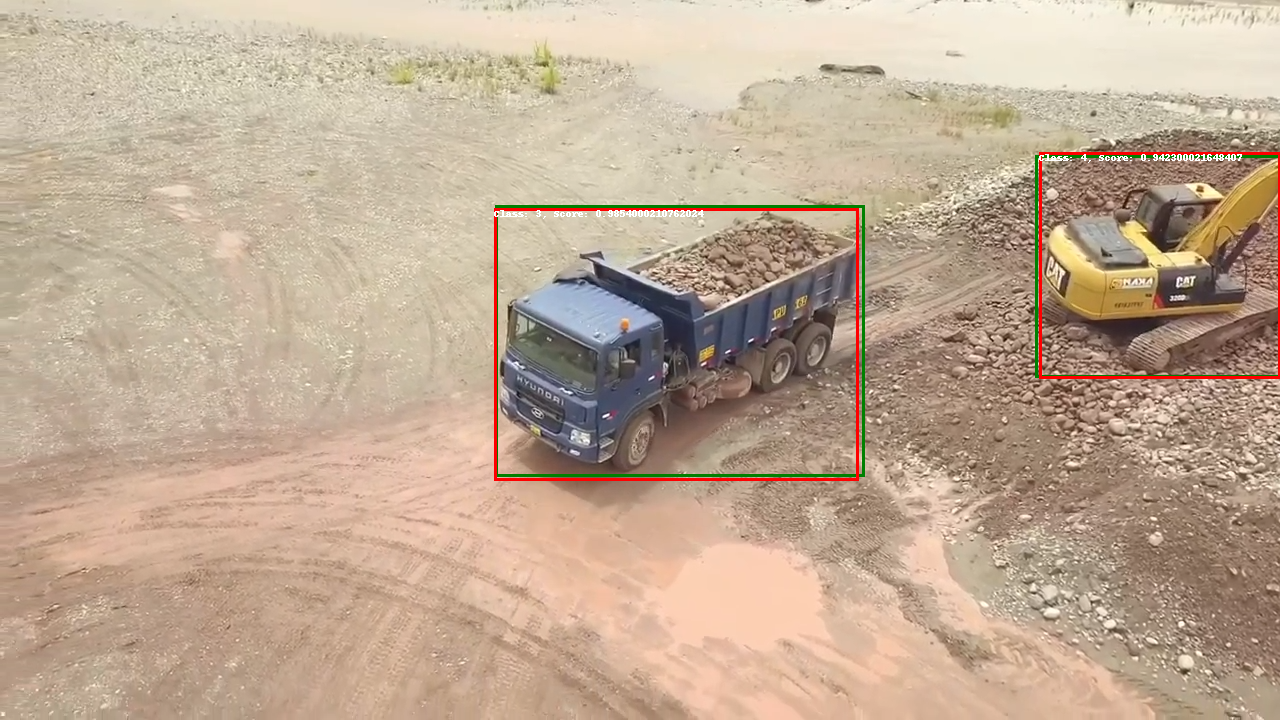

In [ ]:
idx = 212
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])],
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   class_id = prediction[0]["labels"][element].cpu().numpy()  # Obtener el número de clase

   if score > 0.75:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text=f"Class: {class_id}, Score: {score}")
image